##  ANUSPLIN climatology using Cartopy

Agriculture and Agri-Food Canada have produced daily precipitation, minimum and maximum temperature across Canada (south of 60°N) for climate related application purpose using thin-plate smoothing splines, as implemented in the ANUSPLIN climate modeling software (Hutchinson et al., 2009; McKenney et al., 2011).

The so-called ANUSPLIN data uses ground-based observations and generates daily gridded data from 1951 to 2017 on a Lambert conformal conic projection with 5’ arc minutes spacing (equivalent to a resolution of about 10 km). The key strength of this spatial interpolation method is its global dependence on all data, permitting robust and stable determination of spatially varying dependences on elevation. Hutchinson et al. (2009) have shown that while ANUSPLIN fall month’s absolute errors were remarkably small, those of winter months were quite large due to rather difficult observation and measurement conditions.

Data are available on:

ftp://ftp.nrcan.gc.ca/pub/outgoing/canada_daily_grids


In this post, we will see how to use Cartopy with Netcdf in order to display a nice climatology. 

We will display a climatoly of ANUSPLIN from 1981 to 2010.

This dataset is only availabe with ascii grid format, I'll here show how to convert it into Netcdf using Python in an other post. 

The Cartopy python library allows you to analyze, process and plot georeferenced data with the help of Matplotlib.

https://scitools.org.uk/cartopy/docs/latest/#

We first import our librairies:

In [3]:
from netCDF4 import Dataset, num2date
import warnings
warnings.filterwarnings("ignore")
import datetime
import xarray as xr
import pandas as pd
filename='K:/DATA/ANUSPLIN_10km/Netcdf/all_domaine/YEAR/Mean_tasmoy/ANUSPLIN_10km_MEAN_YEAR_Mean_tasmoy_1950-2017.nc'
nc_fid=Dataset(filename,'r')
nc_fid.variables

OrderedDict([('lon', <class 'netCDF4._netCDF4.Variable'>
              float32 lon(y, x)
                  units: degrees_east
                  long_name: Longitude
                  CoordinateAxisType: Lon
              unlimited dimensions: 
              current shape = (1068, 510)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('lat', <class 'netCDF4._netCDF4.Variable'>
              float32 lat(y, x)
                  units: degrees_north
                  long_name: Latitude
                  CoordinateAxisType: Lat
              unlimited dimensions: 
              current shape = (1068, 510)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('time', <class 'netCDF4._netCDF4.Variable'>
              float64 time(time)
                  long_name: Time
                  delta_t: 
              unlimited dimensions: 
              current shape = (68,)
              filling on, default _FillValue o

In [4]:
data=nc_fid.variables['Mean_tasmoy'][:].squeeze()
lons=nc_fid.variables['lon'][:].squeeze()
lats=nc_fid.variables['lat'][:].squeeze()
time = nc_fid.variables['time']

In [5]:
data.shape

(68, 1068, 510)

In [7]:
data_m = data[32:62,:,:]
clim_81_2010=data_m.mean(axis=0)

In [8]:
clim_81_2010.shape

(1068, 510)

We will add some cities to display on our map. We first need to create a dataframe with names of stations and localisations.

In [10]:
names=['Whitehorse','Yellowknife','Iqaluit','Victoria','Edmonton','Regina','Winnipeg','Toronto','Ottawa','Quebec','Halifax','Charlottetown','St-John s']

In [11]:
latitudes=[60.721188,62.453972,63.748611,48.407326,53.631611,50.445210,
          49.895077,43.651070,45.424721,46.829853,44.651070,46.238888,47.560539]
longitudes=[-135.056839,-114.371788,-68.519722,-123.329773,-113.323975,-104.618896,
           -97.138451,-79.347015,-75.695000,-71.254028,-63.582687,-63.129166,-52.712830]

In [12]:
df = pd.DataFrame(list(zip(names, latitudes, longitudes)), 
               columns =['Names', 'latitudes', 'longitudes']) 
df

,Names,latitudes,longitudes
0,Whitehorse,60.721188,-135.056839
1,Yellowknife,62.453972,-114.371788
2,Iqaluit,63.748611,-68.519722
3,Victoria,48.407326,-123.329773
4,Edmonton,53.631611,-113.323975
5,Regina,50.445210,-104.618896
6,Winnipeg,49.895077,-97.138451
7,Toronto,43.651070,-79.347015
8,Ottawa,45.424721,-75.695000
9,Quebec,46.829853,-71.254028


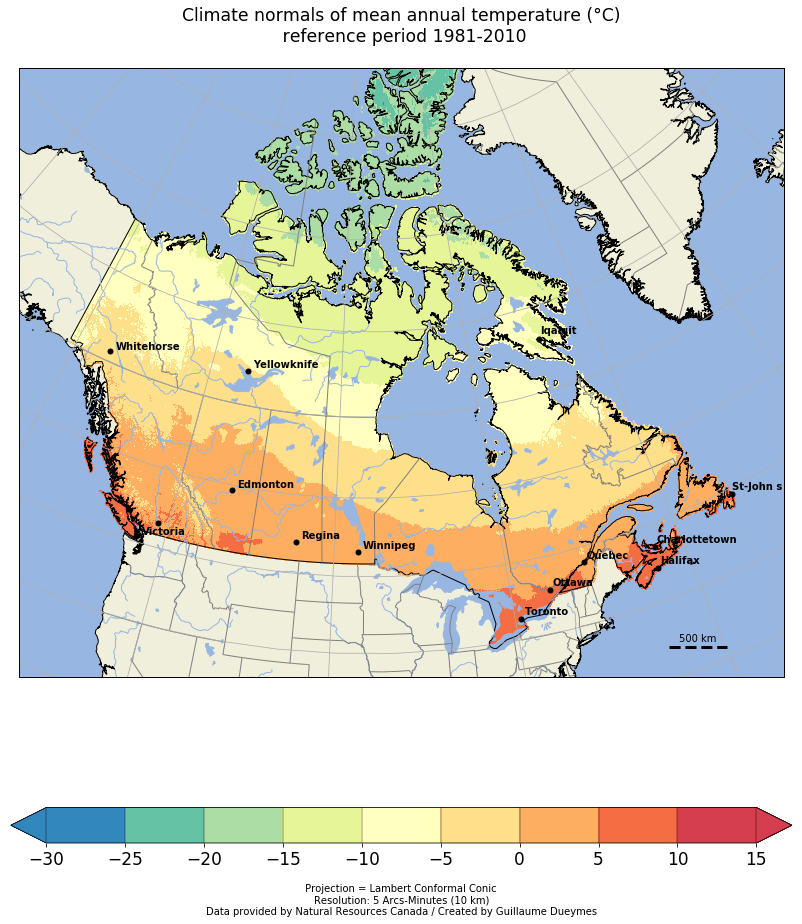

In [14]:
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib as mpl
from carto import scale_bar

Y=np.array([[50,136,189],[102,194,165],[171,221,164],[230,245,152],\
               [255,255,191],[254,224,139],[253,174,97],[244,109,67],[213,62,79]])/255.

colbar=mpl.colors.ListedColormap(Y)
fig=plt.figure(figsize=(28,16), frameon=True)  
ax = plt.subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-130,-55,35,80])
 #ax.coastlines(resolution='110m');
ax.add_feature(cfeature.OCEAN.with_scale('50m'))      # couche ocean
ax.add_feature(cfeature.LAND.with_scale('50m'))       # couche land
ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
   
ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche rivières 
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',     # ajout de la couche cotière 
                            facecolor='none', name='coastline')
ax.add_feature(coast, edgecolor='black')    
states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='10m',
            facecolor='none')
    
ax.add_feature(states_provinces, edgecolor='gray') 

ax.plot(df['longitudes'], df['latitudes'], 'ko', ms=5, transform=ccrs.Geodetic())

for lg, lt, name in zip(df['longitudes'], df['latitudes'], df['Names']):
    if name in [u'Nazaré', 'Marinha Grande']:
        ax.text(lg - .05, lt + .05, 
                name, 
                va='center', 
                ha='right', transform=ccrs.Geodetic(), fontweight='bold')
    else:    
        ax.text(lg + .5, lt + .5, 
                name, 
                va='center', 
                ha='left', transform=ccrs.Geodetic(), fontweight='bold')
        
 
mm = ax.pcolormesh(lons,\
                   lats,\
                   clim_81_2010,\
                   vmin=-30,\
                   vmax=15, \
                   transform=ccrs.PlateCarree(),\
                   cmap=colbar )
ax.gridlines()

# Define gridline locations and draw the lines using cartopy's built-in gridliner:
xticks = np.arange(-150.0,-40.0,20)
yticks =np.arange(10,80,10)

# Standard 6,000 km scale bar.
scale_bar(ax, (0.85, 0.05), 500 ,plot_kwargs = dict(linestyle='dashed', color='black'))

cbar = plt.colorbar(mm, orientation='horizontal', shrink=0.5, drawedges='True', ticks=np.arange(-30, 15.1, 5),extend='both')
cbar.set_label(u'\n Projection = Lambert Conformal Conic \nResolution: 5 Arcs-Minutes (10 km)\nData provided by Natural Resources Canada / Created by Guillaume Dueymes', size='medium') # Affichage de la légende de la barre de couleur
cbar.ax.tick_params(labelsize=17) 
 
plt.xlabel(u'\n\n\nTemperature / Température (°C)',size='x-large')
string_title=u'Climate normals of mean annual temperature (°C)\n reference period 1981-2010\n'
plt.title(string_title, size='xx-large')
plt.savefig('./ANUSPLIN_NLDAS_10km_YEAR_CLIM_1981-2010.png', bbox_inches='tight', pad_inches=0.1)
plt.show() 
